<h2> We will use pretraind models from keras and use their weights instead of writing a new model for classification<h2>

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

<h2>Create instance of pretrained ResNet50 model and remove the top layer, since we will add our fully connected layer on top of it<h2>

In [2]:
vgg = VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)
# resnet = ResNet50(input_tensor=Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)

W0401 23:25:10.118863 140607156631360 deprecation.py:506] From /home/sudesh/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<h2>Don't train existing weights, we are going to use pretrained weights<h2>

In [3]:
for layer in vgg.layers:
    layer.trainable = False

<h2>glob is useful for getting number of classes, especially when no of class are huge<h2>

In [4]:
folders = glob('dataset/train/*')

In [5]:
headModel = vgg.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(folders), activation="softmax")(headModel)

In [6]:
# Construct model
model = Model(inputs=vgg.input, outputs=headModel)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

<h2>Compile the model with appropriate loss, optimizer and metrics<h2>

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

<h2>
Since we dont want to load all the images in memory at once so we will use flow_from_directory from ImageDataGenerator
<h2>
https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

In [8]:
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory('dataset/train',
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

test_generator = test_datagen.flow_from_directory('dataset/valid',
                                            target_size=(224, 224),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=False)

Found 138 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


<h2>Calculate the step per epoch for training and validation dataset<h2>

In [9]:
EPOCHS = 10
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=test_generator.n // test_generator.batch_size

<h2>Train the model<h2>

In [10]:
H = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps=STEP_SIZE_VALID
)

Epoch 1/10
17/17 [==============================] - 57s 3s/step - loss: 1.7612 - acc: 0.7385 - val_loss: 0.1859 - val_acc: 0.9750
Epoch 2/10
17/17 [==============================] - 57s 3s/step - loss: 0.4228 - acc: 0.8846 - val_loss: 0.1418 - val_acc: 0.9750
Epoch 3/10
17/17 [==============================] - 60s 4s/step - loss: 0.2846 - acc: 0.9154 - val_loss: 0.1699 - val_acc: 0.9750
Epoch 4/10
17/17 [==============================] - 57s 3s/step - loss: 0.1385 - acc: 0.9615 - val_loss: 0.0466 - val_acc: 0.9750
Epoch 5/10
17/17 [==============================] - 59s 3s/step - loss: 0.1299 - acc: 0.9538 - val_loss: 0.0345 - val_acc: 0.9750
Epoch 6/10
17/17 [==============================] - 57s 3s/step - loss: 0.1901 - acc: 0.9385 - val_loss: 0.0713 - val_acc: 0.9750
Epoch 7/10
17/17 [==============================] - 60s 4s/step - loss: 0.0590 - acc: 0.9769 - val_loss: 0.0469 - val_acc: 0.9750
Epoch 8/10
17/17 [==============================] - 62s 4s/step - loss: 0.0508 - acc: 0.97

In [11]:
model.save('covid-19-detection.h5')

<h2>Plot loss and accuracy for both training and validation<h2>

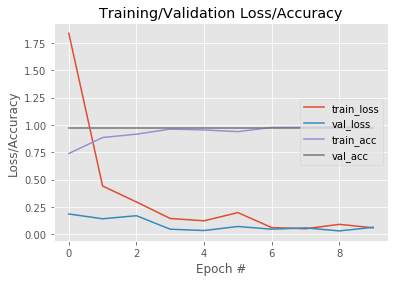

In [12]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training/Validation Loss/Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("loss_acc.png")

In [13]:
def predict_covid(xray_img):
    model = load_model('covid-19-detection.h5')
    img = image.load_img(xray_img, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    covid_prob = model.predict(img_data)
    classes = covid_prob.argmax(axis=1)
    labels = ["Covid", "Normal"]
    return labels[classes[0]]

In [14]:
# Results are looking promising
print(predict_covid('dataset/valid/covid/nejmc2001573_f1b.jpeg'))
print(predict_covid('dataset/valid/normal/IM-0244-0001.jpeg'))

W0401 23:34:54.372066 140607156631360 deprecation.py:506] From /home/sudesh/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0401 23:34:54.373695 140607156631360 deprecation.py:506] From /home/sudesh/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Covid
Normal


In [15]:
print(test_generator.class_indices)

print(test_generator.classes)

{'covid': 0, 'normal': 1}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


<h4>
Before using model.predict_generator to predict classes for validation dataset make sure that while generating images using flow_from_directory shuffle=False is supplied because if images are shuffled the predicted values and lables will not match and hence will produce wrong classification report and confusion matrix
I was having this issue and figured out this by predicting all images individually and varified that model is working correctly and problem is label mis-matching 
<h4>
   <code>
from imutils import paths
        
import os
        
imagePaths = sorted(list(paths.list_images('dataset/valid')))
        
for imagePath in imagePaths:
    print(imagePath)
    print(predict_covid(imagePath))
<code> 

In [16]:
Y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

5/5 [==============================] - 12s 2s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<h2>Classification report<h2>

In [17]:
target_names = ['Covid', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Covid       1.00      0.95      0.97        20
      Normal       0.95      1.00      0.98        20

   micro avg       0.97      0.97      0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



<h2>Confusion matrix<h2>

In [18]:
cm = confusion_matrix(test_generator.classes, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[19  1]
 [ 0 20]]
acc: 0.9750
sensitivity: 0.9500
specificity: 1.0000
